In [1]:
!pip install open3d
!pip install plyfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.

In [4]:
!unzip pipe_segmentations.zip

Archive:  pipe_segmentations.zip
   creating: pipe_segmentations/
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_3_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_3_downsample_10_without_ears_seg_pipes.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b-4-a_L2_part_4_downsample_10_without_ears_seg_basis.ply  
  inflating: pipe_segmentations/2024-09-02_155419_243301-12_tray-b

In [ ]:
%reset -f

In [30]:
import torch
import torch.nn as nn
import open3d as o3d
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from plyfile import PlyData, PlyElement
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

In [42]:
def load_ply_files(folder_path, voxel_size=0.006):  # Adjust voxel_size to control downsampling
    ply_files = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('seg_pipes.ply'):
            filepath = os.path.join(folder_path, filename)
            ply = o3d.io.read_point_cloud(filepath)

            # Apply voxel downsampling to reduce point count
            downsampled_ply = ply.voxel_down_sample(voxel_size)
            ply_files.append(downsampled_ply)
            filenames.append(filename)

            # Display the number of points after downsampling
            print(f"Number of points after downsampling '{filename}': {len(downsampled_ply.points)}")

    print(f"Loaded {len(ply_files)} PLY files with voxel downsampling.")
    return ply_files, filenames


def compute_average_points(ply_files):
    total_points = 0
    num_files = len(ply_files)

    for pcd in ply_files:
        total_points += np.asarray(pcd.points).shape[0]  # Count points in each PLY file

    average_points = total_points / num_files
    return average_points


def preprocess_point_cloud(pcd, num_points=27572):
    pcd_points = np.asarray(pcd.points)
    pcd_colors = np.asarray(pcd.colors)

    if len(pcd_points) < num_points:
        # If there are fewer points, pad with zeros
        padded_points = np.zeros((num_points, 3), dtype=np.float32)
        padded_points[:len(pcd_points)] = pcd_points

        padded_colors = np.zeros((num_points, 3), dtype=np.float32)
        padded_colors[:len(pcd_colors)] = pcd_colors

        return padded_points, padded_colors
    else:
        # Sample points if there are enough
        sampled_indices = np.random.choice(len(pcd_points), num_points, replace=False)
        sampled_points = pcd_points[sampled_indices]
        sampled_colors = pcd_colors[sampled_indices]

        return sampled_points, sampled_colors


def chamfer_distance(p1, p2, batch_size=32):
    total_dist = 0
    num_points = p1.shape[1]
    num_batches = (num_points + batch_size - 1) // batch_size

    for i in range(0, num_points, batch_size):
        p1_batch = p1[:, i:i+batch_size, :]
        p2_batch = p2[:, i:i+batch_size, :]

        p1_coords = p1_batch[:, :, :3]
        p2_coords = p2_batch[:, :, :3]

        dist1_coords, _ = torch.min(torch.cdist(p1_coords, p2_coords), dim=1)
        dist2_coords, _ = torch.min(torch.cdist(p2_coords, p1_coords), dim=1)

        batch_dist = (
            torch.mean(dist1_coords) + torch.mean(dist2_coords)
        )

        total_dist += batch_dist

    normalized_dist = total_dist / num_batches
    return normalized_dist


class PointCloudDataset(Dataset):
    def __init__(self, ply_files, filenames, num_points=27572):
        self.ply_files = ply_files
        self.num_points = num_points
        self.filenames = filenames

    def __len__(self):
        return len(self.ply_files)

    def __getitem__(self, idx):
        pcd = self.ply_files[idx]
        filename = self.filenames[idx]
        points, colors = preprocess_point_cloud(pcd, self.num_points)

        combined = np.concatenate((points, colors), axis=1)  # (num_points, num_features)
        return torch.tensor(combined, dtype=torch.float32), filename


class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 256),  # Fixed to match encoder output size
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 27572 * 6),  # 6 features (3D + RGB)
        )


    def forward(self, x):
        # x shape (batch_size, num_points, num_features)
        x = x.transpose(1, 2)  # Change shape to (batch_size, num_features, num_points)
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten to (batch_size, 512)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 27572, 6)  # Reshaped to original shape

        reconstructed_points = decoded[:, :, :3]
        reconstructed_colors = torch.sigmoid(decoded[:, :, 3:])

        return torch.cat((reconstructed_points, reconstructed_colors), dim=2)


def train_autoencoder(model, data_loader, optimizer, num_epochs=50, device='cpu'):
    model.train()
    all_coord_errors = []
    all_color_errors = []
    all_points = []
    accumulation_steps = 4
    scaler = torch.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        for i, (data, filename) in enumerate(data_loader):
            data = data.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):  # Use mixed precision
                reconstructed = model(data)  # Forward pass

                # Compute Chamfer distance loss
                loss = chamfer_distance(reconstructed, data)

                # Scale the loss and perform backpropagation
                scaler.scale(loss).backward()

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            all_coord_errors.append(loss.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    return all_coord_errors

In [35]:
folder_path = '/content/pipe_segmentations'
ply_files, filenames = load_ply_files(folder_path)
average_points = compute_average_points(ply_files)

print(f"Average number of points: {average_points}")

Number of points after downsampling '2024-09-02_161540_243301-13_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_pipes.ply': 25251
Number of points after downsampling '2024-09-02_161540_243301-13_tray-b-4-e_L2_part_1_downsample_10_without_ears_seg_pipes.ply': 27667
Number of points after downsampling 'tray-b-4-c_L2_part_1_downsample_10_without_ears_seg_pipes.ply': 27436
Number of points after downsampling '2024-09-02_155419_243301-12_tray-b-4-d_L2_part_4_downsample_10_without_ears_seg_pipes.ply': 29883
Number of points after downsampling 'tray-b-4-g_L2_part_3_downsample_10_without_ears_seg_pipes.ply': 25783
Number of points after downsampling '2024-09-02_161540_243301-13_tray-b-4-e_L2_part_3_downsample_10_without_ears_seg_pipes.ply': 27429
Number of points after downsampling '2024-09-02_161540_243301-13_tray-b-4-d_L2_part_3_downsample_10_without_ears_seg_pipes.ply': 28942
Number of points after downsampling '2024-09-02_161540_243301-13_tray-b-4-c_L2_part_3_downsample_10_without_ear

In [43]:
# Create a dataset and dataloader
dataset = PointCloudDataset(ply_files, filenames)
data_loader = DataLoader(dataset, batch_size=20, pin_memory=True)

# Initialize model, optimizer
device = torch.device("cuda")
model = PointNetAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
all_coord_errors = train_autoencoder(model, data_loader, optimizer, num_epochs=40, device=device)

Epoch [1/40], Loss: 0.2843644618988037
Epoch [2/40], Loss: 0.21084152162075043
Epoch [3/40], Loss: 0.18517357110977173
Epoch [4/40], Loss: 0.17598919570446014
Epoch [5/40], Loss: 0.17228031158447266
Epoch [6/40], Loss: 0.1699649840593338
Epoch [7/40], Loss: 0.16848520934581757
Epoch [8/40], Loss: 0.16732797026634216
Epoch [9/40], Loss: 0.16641291975975037
Epoch [10/40], Loss: 0.1660018265247345
Epoch [11/40], Loss: 0.16558876633644104
Epoch [12/40], Loss: 0.16539888083934784
Epoch [13/40], Loss: 0.16509513556957245
Epoch [14/40], Loss: 0.1647326946258545
Epoch [15/40], Loss: 0.1645026057958603
Epoch [16/40], Loss: 0.16466687619686127
Epoch [17/40], Loss: 0.16441987454891205
Epoch [18/40], Loss: 0.16475433111190796
Epoch [19/40], Loss: 0.16511447727680206
Epoch [20/40], Loss: 0.16437730193138123
Epoch [21/40], Loss: 0.16404037177562714
Epoch [22/40], Loss: 0.16441619396209717
Epoch [23/40], Loss: 0.16414514183998108
Epoch [24/40], Loss: 0.16451559960842133
Epoch [25/40], Loss: 0.1644294

In [45]:
data_iter = iter(data_loader)
original_data , filename = next(data_iter)
original_data = original_data.to(device)

model.eval()

with torch.no_grad():
    reconstructed_data = model(original_data)

cloud_idx = 1

original_points = original_data[cloud_idx, :, :3].cpu().numpy()
original_colors = original_data[cloud_idx, :, 3:].cpu().numpy()

reconstructed_points = reconstructed_data[cloud_idx, :, :3].cpu().numpy()
reconstructed_colors = reconstructed_data[cloud_idx, :, 3:].cpu().numpy()

# Range analysis
print("Original points range:")
print(np.min(original_points, axis=0), np.max(original_points, axis=0))

print("Reconstructed points range:")
print(np.min(reconstructed_points, axis=0), np.max(reconstructed_points, axis=0))

print("Original color range:")
print(np.min(original_colors, axis=0), np.max(original_colors, axis=0))

print("Reconstructed color range:")
print(np.min(reconstructed_colors, axis=0), np.max(reconstructed_colors, axis=0))

Original points range:
[-0.3618396  -0.60759056 -0.00983364] [0.403368   0.6193278  0.00333054]
Reconstructed points range:
[-0.35444397 -0.60558105 -0.10220134] [0.35651028 0.5665609  0.06848502]
Original color range:
[0.09019608 0.09019608 0.09019608] [1. 1. 1.]
Reconstructed color range:
[0.46688876 0.46669576 0.46838987] [0.5319986 0.5343899 0.5323177]


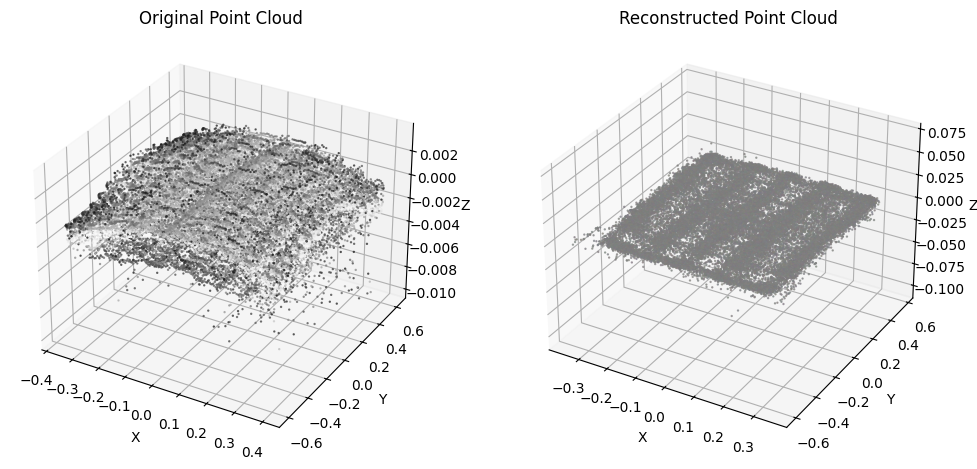

In [46]:
def plot_point_cloud_3d(points, colors, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o', s=0.5, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud_3d(original_points, original_colors, title="Original Point Cloud", ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud_3d(reconstructed_points, colors=reconstructed_colors, title="Reconstructed Point Cloud", ax=ax2)

plt.show()

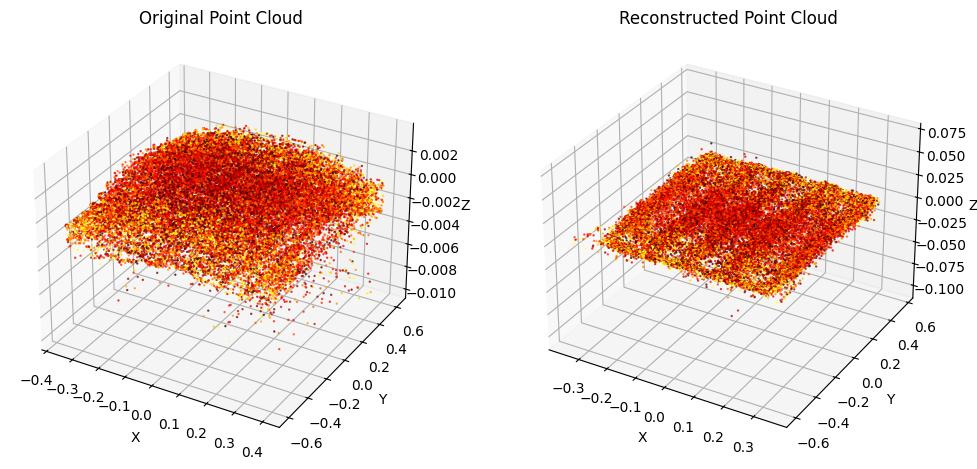

In [47]:
# Per-point Euclidean distance
def compute_errors(original_points, reconstructed_points):
    original_points = torch.tensor(original_points, dtype=torch.float32)
    reconstructed_points = torch.tensor(reconstructed_points, dtype=torch.float32)

    coord_errors = torch.norm(original_points - reconstructed_points, dim=1)
    return coord_errors

coord_errors = compute_errors(original_points, reconstructed_points)
coord_errors_normalized = (coord_errors - coord_errors.min()) / (coord_errors.max() - coord_errors.min())

colormap = plt.colormaps['hot']
colors = colormap(coord_errors_normalized.numpy())[:, :3]  # Use RGB part of colormap

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud_3d(original_points, colors, title="Original Point Cloud", ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud_3d(reconstructed_points, colors, title="Reconstructed Point Cloud", ax=ax2)

plt.show()

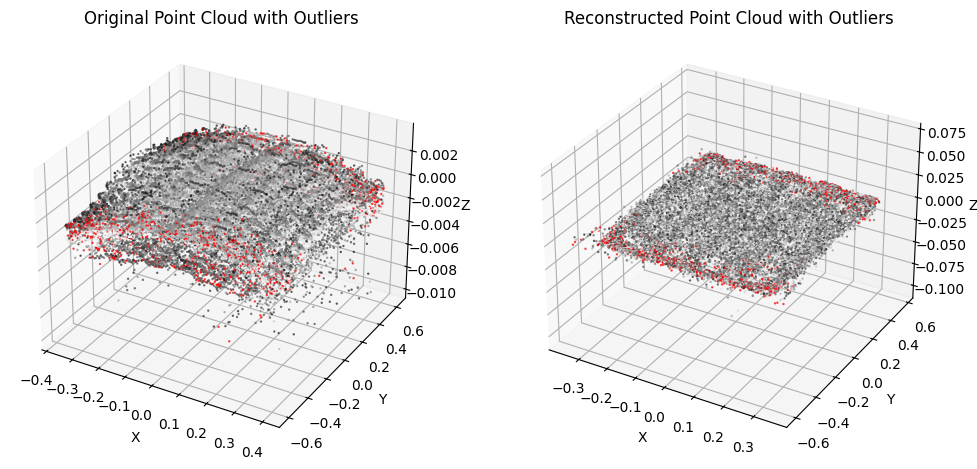

In [48]:
def get_outliers(errors, top_percent=1):
    threshold = np.percentile(errors, 100 - top_percent)
    outliers = errors >= threshold
    return outliers

def plot_point_cloud_with_outliers(pcd_points, errors, outliers, original_colors, title="Point Cloud with Outliers", ax=None):
    colors = np.copy(original_colors)  # Copy the original colors
    colors[outliers] = [1, 0, 0]  # Mark outliers in red
    plot_point_cloud_3d(pcd_points, colors, title=title, ax=ax)

outliers = get_outliers(coord_errors.numpy(), top_percent=5)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud_with_outliers(original_points, coord_errors.numpy(), outliers, original_colors, title="Original Point Cloud with Outliers", ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud_with_outliers(reconstructed_points, coord_errors.numpy(), outliers, original_colors, title="Reconstructed Point Cloud with Outliers", ax=ax2)

plt.show()

<ipython-input-70-bea94f98747f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet', n_clusters)  # Use 'jet' colormap for clusters


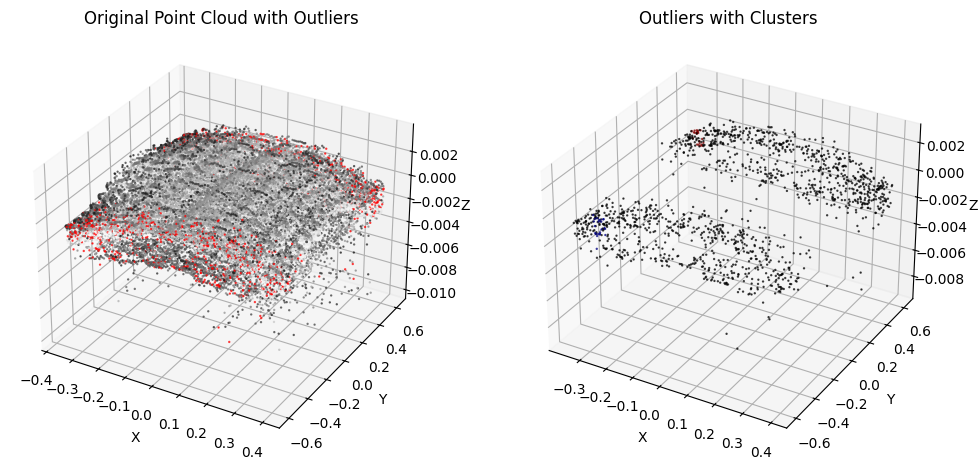

In [70]:
# Extract outlier points
outlier_points = original_points[outliers]

# Apply DBSCAN clustering on outlier points
dbscan = DBSCAN(eps=0.02, min_samples=20)  # Adjust `eps` and `min_samples` as needed
outlier_clusters = dbscan.fit_predict(outlier_points)

# Assign colors to clusters
# Create a colormap for the clusters, with noise (cluster -1) in black
unique_clusters = set(outlier_clusters)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Exclude noise if present
colormap = cm.get_cmap('jet', n_clusters)  # Use 'jet' colormap for clusters

# Map each point to a color based on cluster
cluster_colors = np.array([colormap(c % n_clusters) if c != -1 else [0, 0, 0, 1] for c in outlier_clusters])

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud_with_outliers(original_points, coord_errors.numpy(), outliers, original_colors, title="Original Point Cloud with Outliers", ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud_3d(outlier_points, colors=cluster_colors[:, :3], title="Outliers with Clusters", ax=ax2)

plt.show()

In [71]:
def save_point_cloud_as_ply(points, colors, filename, filename_suffix="_clustered.ply"):
    """
    Save the point cloud to a PLY file with the provided points and colors in a specified folder.
    """
    base_filename = os.path.splitext(os.path.basename(filename))[0]  # Get the file name without extension
    new_filename = f"{base_filename}{filename_suffix}"

    # Create point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ensure the folder exists and save the file
    folder_path = "saved_clusters2"  # Define your folder path where to collect all the files
    os.makedirs(folder_path, exist_ok=True)
    full_filename = os.path.join(folder_path, new_filename)

    o3d.io.write_point_cloud(full_filename, pcd)
    print(f"Saved point cloud as {full_filename}")

# Save the original point cloud with its filename (as used in the dataloader)
def save_original_point_cloud(original_points, original_colors, filename):
    save_point_cloud_as_ply(original_points, original_colors, filename, filename_suffix="_original.ply")

# Save clustered outliers as their own files
def save_clustered_outliers(outlier_points, outlier_clusters, filename):
    unique_clusters = set(outlier_clusters)
    n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Exclude noise if present

    colormap = cm.get_cmap('jet', n_clusters)  # Using 'jet' colormap for clusters

    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Skip noise
            continue

        # Assign a unique color to each cluster
        cluster_color = colormap(cluster_id % n_clusters)[:3]  # RGB values
        cluster_points = outlier_points[outlier_clusters == cluster_id]

        # Assign the same color to the points in the cluster
        cluster_colors = np.tile(cluster_color, (cluster_points.shape[0], 1))

        # Save the cluster points
        save_point_cloud_as_ply(cluster_points, cluster_colors, filename, filename_suffix=f"_cluster_{cluster_id}.ply")

# Usage Example:
# Assuming `original_points`, `original_colors`, `filename`, `outliers`, and `outlier_clusters` are available

# 1. Save the original point cloud
save_original_point_cloud(original_points, original_colors, filename[cloud_idx])

# 2. Save clustered outliers (if any) as separate files with their own colors
outlier_points = original_points[outliers]  # Get the outlier points
outlier_clusters = dbscan.fit_predict(outlier_points)  # Assuming DBSCAN clustering has been done

save_clustered_outliers(outlier_points, outlier_clusters, filename[cloud_idx])

Saved point cloud as saved_clusters2/2024-09-02_161540_243301-13_tray-b-4-e_L2_part_1_downsample_10_without_ears_seg_pipes_original.ply
Saved point cloud as saved_clusters2/2024-09-02_161540_243301-13_tray-b-4-e_L2_part_1_downsample_10_without_ears_seg_pipes_cluster_0.ply
Saved point cloud as saved_clusters2/2024-09-02_161540_243301-13_tray-b-4-e_L2_part_1_downsample_10_without_ears_seg_pipes_cluster_1.ply


<ipython-input-71-e67de9bfcc27>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet', n_clusters)  # Using 'jet' colormap for clusters


In [72]:
import shutil
from google.colab import files

# Step 1: Zip the folder
folder_path = 'saved_clusters2'  # Replace with your folder path
zip_name = 'saved_clusters2'  # The name for the zip file

shutil.make_archive(zip_name, 'zip', folder_path)

'/content/saved_clusters2.zip'